In [485]:
# Import necessary modules:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, r2_score
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exploratory Data Anlysis:

In [460]:
# Read three datasets. Rename email_id columns in email_opened_table and link_clicked_table to make it easier
# for an outer merge later:
email_1 = pd.read_csv('email_table.csv')
email_2 = pd.read_csv('email_opened_table.csv').rename(columns={'email_id':'opened'})
email_3 = pd.read_csv('link_clicked_table.csv').rename(columns={'email_id':'clicked'})

In [461]:
# Merge email_2 and email_3 with email_1, which includes all metadata necessary for modeling: 
email = email_1.merge(email_2, left_on='email_id', right_on='opened', how='outer')
emails = email.merge(email_3, left_on='email_id', right_on='clicked', how='outer')

In [462]:
# Transform email_id and NaN values in opened and clicked to 0 (NaN) and 1 for any other non-null values. 
# NaN means the email has not beened opened or the linked not clicked. 1 means vice versa:
emails['opened'] = emails['opened'].apply(lambda x: 1 if not pd.isnull(x) else 0)
emails['clicked'] = emails['clicked'].apply(lambda x: 1 if not pd.isnull(x) else 0)

In [463]:
# Remove email_id as it's not necessary for the analysis (in this project):
emails = emails.drop(['email_id'], axis=1)

In [464]:
# Take a look at the dataset after merging and some preprocessing: 
emails.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,short_email,personalized,2,Sunday,US,5,0,0
1,long_email,personalized,12,Sunday,UK,2,1,1
2,long_email,personalized,11,Wednesday,US,2,0,0
3,short_email,generic,6,Monday,UK,1,0,0
4,long_email,generic,14,Monday,US,6,0,0


In [465]:
# Get a copy of the dataset for later patterns exploration:
emails_1 = emails.copy()

In [466]:
# Describe the dataset to check if there's no nonsense, especially for hour and user purchases.
# Hour ranges from 1 to 24. This makes sense, so it's unnecessary to change or remove any row. User past purchases
# also range from 0 to 22, which seems fine for now:
emails.describe()

,hour,user_past_purchases,opened,clicked
count,100000.000000,100000.00000,100000.000000,100000.000000
mean,9.059300,3.87845,0.103450,0.021190
std,4.439637,3.19611,0.304547,0.144018
min,1.000000,0.00000,0.000000,0.000000
25%,6.000000,1.00000,0.000000,0.000000
50%,9.000000,3.00000,0.000000,0.000000
75%,12.000000,6.00000,0.000000,0.000000
max,24.000000,22.00000,1.000000,1.000000


Every time an email is opened or a link clicked, opened and clicked columns sum would accumulate by 1.
Hence, there is about 10.35 percent of total emails sent get opened. Approximately, 2.12 percent of total 
emails sent get opened and the linked inside clicked.

=> These low percentages of opened emails and clicked links suggest a servere class imbalance that we have to deal with later.

In [467]:
# Check if there is any missing observations: 
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 8 columns):
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null int64
clicked                100000 non-null int64
dtypes: int64(4), object(4)
memory usage: 6.9+ MB


In [468]:
# Check if the number of emails sent to different countries are the same:
emails.groupby('user_country').count()

,email_text,email_version,hour,weekday,user_past_purchases,opened,clicked
user_country,,,,,,,
ES,9967,9967,9967,9967,9967,9967,9967
FR,9995,9995,9995,9995,9995,9995,9995
UK,19939,19939,19939,19939,19939,19939,19939
US,60099,60099,60099,60099,60099,60099,60099


Text(0.5,1,'Click Rate by Hour')

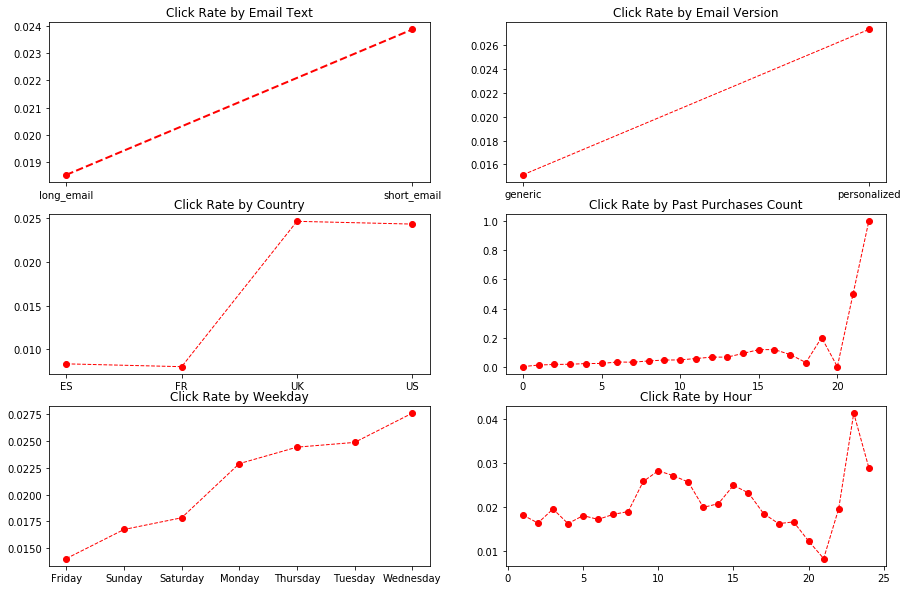

In [469]:
# Visualize the relationship of each feature with the target 
#(percentage of emails opened and the link inside clicked):

# Percentage of click counts by long and short email text.
# Use mean method because the number of emails sent to different customer segments are different 
# (Total count would be biased then.)
text = emails.groupby('email_text')['clicked'].mean() 
version = emails.groupby('email_version')['clicked'].mean()
country = emails.groupby('user_country')['clicked'].mean()
purchases = emails.groupby('user_past_purchases')['clicked'].mean()
weekday_1 = pd.DataFrame(emails.groupby('weekday')['clicked'].mean()).sort_values(by=['clicked'])
weekday = weekday_1['clicked']
hour = emails.groupby('hour')['clicked'].mean()

plt.figure(figsize=(15,10))

plt.subplot(3,2,1)
plt.plot(text, color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=6)
plt.title('Click Rate by Email Text')

plt.subplot(3,2,2)
plt.plot(version, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Email Version')

plt.subplot(3,2,3)
plt.plot(country, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Country')

plt.subplot(3,2,4)
plt.plot(purchases, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Past Purchases Count')

plt.subplot(3,2,5)
plt.plot(weekday_1, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Weekday')

plt.subplot(3,2,6)
plt.plot(hour, color='red', marker='o', linestyle='dashed',
        linewidth=1, markersize=6)
plt.title('Click Rate by Hour')

1. More short emails get opened and the link inside clicked. This is understandable. Most people don't have too much time reading advertising emails. Hence, it's faster and more tempting to get to the link in a short one. 
2. Personalized emails get opened and the link inside clicked much more often. 
3. The company mainly focuses on US and UK markets. Most emails are sent to customers in these countries.
ES and FR markets are doing very poorly in terms of click rate.
4. Though the number of emails sent to US customers tops the list among four countries (approximately three times the number of emails sent to UK customers). However, the UK customers seem more active with the highest click rate.
5. New customers don't often open and click the link inside their emails. Returners, especially those with more than 5 past purchases are more likely to click the link.
6. There are several outliners in click rate by past purchases counts. Customers with more than about 22 past purchases always open the link inside their email. This takes further investigation.
7. Customers are more likely to open link inside their emails during weekdays. Friday bottoms the list of click rate by weekday. This is understandatble. 
8. The click rate is highest from 10-16 everyday. Combined with the previous insihgt, it seems that most customers check advertising emails and open ad links at work. This can be a valuable insight for the content creation and marketing teams. 
9. There are also outliners when it comes to click rate by hour. At 11PM, the click rate is much higher than earlier in the day. This needs further investigation.

In [470]:
# Take a look at returners with higher than 20 past purchases:
emails[emails['user_past_purchases'] > 20]

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
5123,long_email,personalized,16,Monday,US,22,1,1
10366,long_email,generic,12,Monday,US,21,0,0
13885,long_email,generic,14,Tuesday,FR,21,1,1
24535,short_email,personalized,9,Tuesday,UK,21,0,0
32881,short_email,generic,7,Wednesday,UK,21,1,1


They have much higher click rate than the overall rate but the group is only of 5. 

In [471]:
# Take a look at customers clicking provided link very late:
print(emails[emails['hour'] == 23]['clicked'].mean())
print(emails[emails['hour'] == 23]['clicked'].count())

0.041379310344827586
145


Though the click rate at 23 is much higher than earlier hours in the day, there are only 145 customers have this behavior.
So there is not really a pattern that we can exploit here.

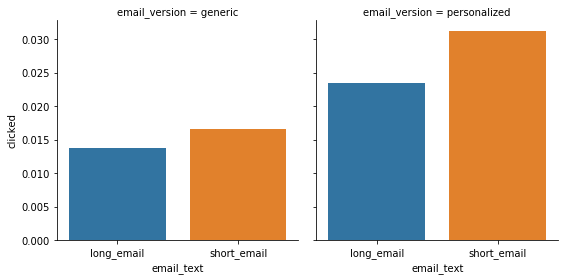

In [472]:
# Short email and personalized email separately increase click rate. Check the interaction between these
# two features:
fg = sns.factorplot(x='email_text', 
                    y='clicked',
                    col='email_version', 
                    data=emails.groupby(['email_text', 'email_version'])['clicked'].mean().to_frame().reset_index(), 
                    kind='bar')

Personalized short emails are those with highest click rate. It might be helpful to create an interaction feature of these two features.

# 2. Prepare Data for Analysis

In [473]:
# I will use random forest and decision tree models later. Hence, it's suitable to label encode 
# several features in the dataset:
lb = LabelEncoder()
emails['email_text'] = lb.fit_transform(emails['email_text'])
emails['email_version'] = lb.fit_transform(emails['email_version'])

# Because weekdays click rate is higher than weekend. I would create a dummy variable for weekday:
emails['weekday'] = emails['weekday'].apply(lambda x: 1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday'] else 0)

# Office hours yield higher click rate. I also create a dummy variable for hour to reduce effect of outliers:
emails['hour'] = emails['hour'].apply(lambda x: 1 if x in range(4, 16, 1) else 0)

# However, because ES and FR customers have approximatley similar click rate, which is much higher than US and UK
#, I would group them into three groups. Then get dummies from the ordinal feature for further investigation
# in these three markets:
emails['user_country'] = emails['user_country'].apply(lambda x: 0 if x in ['ES', 'FR'] else x)
emails = pd.get_dummies(emails, prefix=['user_country'])

In [474]:
# Create the interaction feature of text_version and email_text
emails['text_version'] = emails['email_text'] * emails['email_version']

In [475]:
# Take a look at the dataset now:
emails.head(5)

,email_text,email_version,hour,weekday,user_past_purchases,opened,clicked,user_country_0,user_country_UK,user_country_US,text_version
0,1,1,0,0,5,0,0,0,0,1,1
1,0,1,1,0,2,1,1,0,1,0,0
2,0,1,1,1,2,0,0,0,0,1,0
3,1,0,1,1,1,0,0,0,1,0,0
4,0,0,1,1,6,0,0,0,0,1,0


In [476]:
# Create features and labels for classification models:
X = emails.drop(['clicked', 'opened'], axis=1)
y = emails[['clicked']]

# Because 0(no click) and 1(clicked) classes are severely imbalanced. Use Stratefied Shuffle Split 
# to shuffle observations and preserve the percentage of classes similar to that in the original dataset.
# This would obviate the situation when all and disproportionately many 1 class observations get divided 
# in either training or test set, which hinders the prediction of the important label.

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)
 
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Check the ratio of two classes in test set:
y_test['clicked'].value_counts()

0    29364
1      636
Name: clicked, dtype: int64

# 3. Modeling

# Random Forest

In [477]:
# True Positive rate is the main concern of this problem. We want to predict who is going to open the link
# provided in emails we send. Therefore, I increase the weight of class 1. 
rf = RandomForestClassifier(class_weight = {0:1, 1:60})
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/Users/tapham18/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Text(0,0.5,'Features')

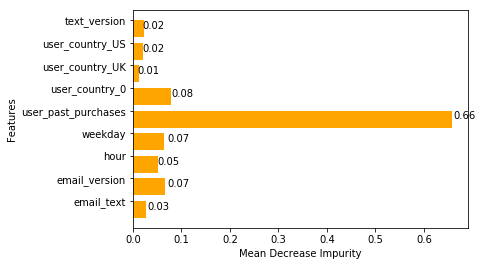

In [478]:
# Plot the importances of different features in the model:
y = rf.feature_importances_
x = X.columns

fig, ax = plt.subplots()    
width = 0.75  
ind = np.arange(len(y))  
ax.barh(ind, y, width, color='orange')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(np.round(y, 2)):
    ax.text(v, i, str(v), color='black')
plt.xlabel('Mean Decrease Impurity')
plt.ylabel('Features')

User_past_purchases is the most important/informative feature in reducing the rest partition impurity. User_country_0 (ES and FR) and email_version rank seconds. Weekday and hour continues the list. Surprisingly, email text is not that informative.

In [479]:
# Create an unnormalized confusion matrix:
confusion_matrix(y_test, y_pred)

array([[17941, 11423],
       [  213,   423]])

/Users/tapham18/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


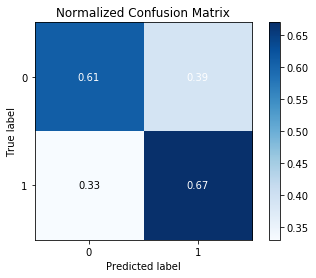

In [480]:
# Create a normalized confusion matrix:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

0: negative.
1: positive.

Here, we have to make a trade-off. To be able to predict 67% of class 1, which is what we care about, we need to accept a fairly low true negative score.
Let's check if it's worth it to make the trade-off, given 67% is a decent number.

/Users/tapham18/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


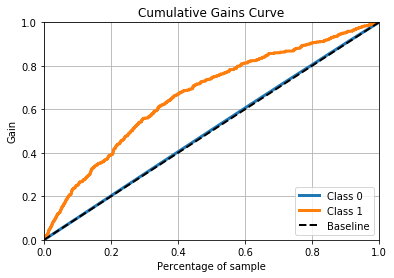

In [481]:
# Calculate proability score for each prediction. Plot the cumulative gain curves, which already sort scores
# in descending order in each decile:
y_probas = rf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

What if we send short personalized emails to US-UK returners with more than 5 purchases from 10-15 Monday to Thursday? 

The cumulative gain of class 1 and baseline tells us by 60 percent of the number of emails sent out, we are already able to predict 80 percent of those who open and click the provided link in each email.
That means 20 percent improvement compared to the campaign if we sent 100000 emails to all random customers.

# Decision Tree

In [482]:
# Build a simple tree to double check the prediction. Pre-prune the tree by limiting max_depth 
# to avoid overfitting:
dt = DecisionTreeClassifier(max_depth = 9, class_weight = {0:1,1:47})
dt.fit(X_train, y_train)
y_pred_2 = dt.predict(X_test)

/Users/tapham18/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


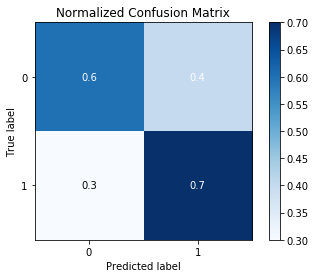

In [483]:
# Create a confustion matrix for the tree:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_2, normalize=True)

A simple decision tree even better than random forest in this case yielding 0.7 true positive and 0.6 true
negative score.

In [484]:
# Print root and top nodes of the tree:
tree.export_graphviz(dt, out_file='trees.dot', max_depth = 9, feature_names = X.columns) 

1. A shallow tree confirms our prediction that user with more than 4.5 purchases would more likely to open emails and click provided links.
2. Shorter and more personalized emails yield higher click rate.
3. Emails sent during week days working hours have higher click rate than weekends.

# Patterns:

In [503]:
# To discover if there is any pattern left, I use a copy of emails: emails_1 dataset.
# Sort weekday value in terms of time (Mon, Tue, ...)
emails_1['weekday'] = pd.Categorical(emails_1['weekday'],
                                   categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                   ordered=True)
emails_2 = emails_1.sort_values('weekday')
emails_2.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
87456,long_email,personalized,1,Monday,FR,4,0,0
13534,short_email,generic,7,Monday,UK,1,0,0
88264,short_email,personalized,11,Monday,UK,6,0,0
88265,short_email,personalized,15,Monday,US,0,0,0
38837,short_email,generic,6,Monday,US,3,0,0


In [493]:
# Split emails_2 into three dataframes according to three country groups:
us = emails_2[emails_2.user_country == 'US']
uk = emails_2[emails_2.user_country == 'UK']
eu = emails_2[emails_2['user_country'].isin(['ES', 'FR'])]

In [501]:
# Groupby hour to see the click rate at different hours in three country groups:
df = us.groupby('hour')['clicked'].mean().to_frame().reset_index()
df = df.rename(columns = {'clicked':'US_clicked'})
df_1 = uk.groupby('hour')['clicked'].mean().to_frame().reset_index()
df_1 = df_1.rename(columns = {'clicked':'UK_clicked'})
df_2 = eu.groupby('hour')['clicked'].mean().to_frame().reset_index()
df_2 = df_2.rename(columns = {'clicked':'EU_clicked'})

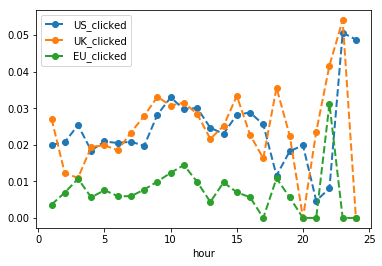

In [502]:
# Visualize the click rate by hour
clicked_by_country_hour = df.merge(df_1, left_on='hour', right_on='hour', how='inner').merge(df_2, left_on='hour', right_on='hour', how='inner')
clicked_by_country_hour.plot(x='hour', y=['US_clicked', 'UK_clicked', 'EU_clicked'],
                            marker='o', linestyle='dashed',
                            linewidth=2, markersize=6)
plt.show()

Interestingly, three lines displaying click rate of three country groups vary in a comparable patterns through out the day. Getting to different local peaks at 9, 10, and 16, then outliners at 22 and 23. 

# 4. Product Recommendations:

1. The campaign is doing fine with US and UK markets. However, we need to figure out why we are doing so poorly in ES and FR. Click rate in these two countries are disproportionately lower than that in US and UK. Maybe the email and link contents haven't adapted to the customer behaviors there.

2. Click rate varies by time and countries. Schedule automatic email sender to send emails to different countries at particular click rate peak time (9, 10, 22, 23).

3. Opened rate is much higher than clicked rate. This might mean people do care about the content of email, however, something wrong (too long, generic, and even boring) discourages them from clicking provided links. Therefore, we should: 

    3.1 Send more short and personalized emails.
    
    3.2 Because most link clicked during office our on weekdays, tailor the email content to make it more appealing to working people during this time frame.
    
4. To check if the campaigns optimizing our model results really increases click rate by approximately 20%, we do an A/B test between two groups at the same time: a group receives long and generic emails during weekend, another recieves short and personal emails during office hours. Then, we check the click rate difference between these two groups. 